In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set2')
import sys
from tqdm.auto import tqdm
np.random.seed(42)
plt.style.use('ggplot')

In [2]:
sys.path.append('../utility')
from concordance_index import concordance_index
from regression_line import abline
from repeated_analysis import repeated_analysis
from cross_validate_random_forest import cross_validate_random_forest
from string_utils import multiple_replace
from feature_selections import recursive_feature_elimination
from norm import tpm

In [3]:
!pwd

/cluster/majf_lab/mtinti/extend_UTRs/ML/decoding-gene-expression/TC


In [4]:
df = pd.read_csv('ML_DATASET.csv.gz',index_col=[0])
df=df.dropna()
print(df.shape)
df.head()

(6800, 56)


,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,utr_3_count_CG,utr_3_count_CT,...,third_base_G,third_base_C,non_optimal_codon,RNA_SRR1587302,RNA_SRR1587303,RNA_SRR1587304,RIBO_SRR1587305,RIBO_SRR1587306,RIBO_SRR1587307,Length
C4B63_40g33,TGCTAAATATATCTATGCATCTGTTGAAAGTGGAGTGTCAGTGCGT...,AGCAATAAAAAAAAAAAACATAGGTATTAAAGCAAGAGGACTGGGA...,ATGGAGCTTGCAAACGCCTTGACGGCGGCTCCGACGCCGATTGTGC...,0.215385,0.546154,0.076923,0.161538,0.761538,0.238462,0.623077,...,0.105370,0.081054,0.306991,1770,2153,2248,1283,711,822,987
C4B63_40g35,GCTGCTAGAAGGAAAGTGAAGGGAGGGAGAGGGGGAGAGGGGAAGA...,GCGTACGGTATGCACCTCTCACTGCTTAGTTGGAATGTCTTTTCCT...,ATGGTATCGTACAAAGAAGGTGTCACTCGCGACGGCCGTAAGCGCG...,0.244949,0.292929,0.191919,0.270202,0.537879,0.462121,0.484848,...,0.114002,0.092937,0.275093,3405,4293,4101,2091,1226,1298,807
C4B63_40g36,CCACAAATGGGTGTTAGGTGAACTTTGAGAGAATGAGAGAAGGGCT...,AATAATAACGGCTACAGCAGCGGGCCGTCGTCGTCGTTGTACCAGG...,ATGCTGCGGAGGAGGGTTCTGCCTGAGAGTCATCGTTACGCCTCAT...,0.344828,0.283525,0.145594,0.226054,0.628352,0.371648,0.429119,...,0.095319,0.076142,0.292724,2730,3225,3244,1802,1280,1300,3546
C4B63_40g124c,GATGTGCGACACGGTGGTGTGGATGGGGGAGAGTAGCGCTTTGTCC...,ATGGCGTTCAATAGATATGTGCATATCCTCTTTTTTTTTTCGTGTG...,ATGGTGGCGGTTCGTGCAAAGGTCGGTTCCCGCGGTTTCGTCCGCC...,0.237179,0.371795,0.179487,0.211538,0.608974,0.391026,0.551282,...,0.145038,0.132316,0.206107,5425,6033,4521,1764,1371,924,393
C4B63_40g37,GTTCTATGGCAATCACCCAGAGGGAGAGGGAGAGAGTGCGAAGGAA...,AGGAGGGAGGCGTGCCGGCTGTCAGGCAGCTGCAACAGTAACTCTC...,ATGCTTCGCCGCACCTCTCTCGCGTGCAGCTACAGAGCCTCGCTCG...,0.347619,0.266667,0.133333,0.252381,0.614286,0.385714,0.400000,...,0.131624,0.083761,0.323077,562,662,694,695,436,609,585


In [5]:
counts_column=['RNA_SRR1587302','RNA_SRR1587303','RNA_SRR1587304']+['RIBO_SRR1587305','RIBO_SRR1587306','RIBO_SRR1587307']
targets = tpm(df[counts_column], df['Length'])
targets['TE']=targets[['RIBO_SRR1587305','RIBO_SRR1587306','RIBO_SRR1587307']].mean(axis=1)/(
    targets[['RIBO_SRR1587305','RIBO_SRR1587306','RIBO_SRR1587307']].mean(axis=1)+targets[['RNA_SRR1587302','RNA_SRR1587303','RNA_SRR1587304']].mean(axis=1))
targets['ribo_counts']=targets[['RIBO_SRR1587305','RIBO_SRR1587306','RIBO_SRR1587307']].mean(axis=1)
targets['rna_counts']=targets[['RNA_SRR1587302','RNA_SRR1587303','RNA_SRR1587304']].mean(axis=1)

In [6]:
df[['TE','ribo_counts','rna_counts']]=targets[['TE','ribo_counts','rna_counts']]

In [7]:
df = df.drop(['RNA_SRR1587302','RNA_SRR1587303','RNA_SRR1587304']+['RIBO_SRR1587305','RIBO_SRR1587306','RIBO_SRR1587307']+['Length'],axis=1)

In [8]:
df['utr_5_ATG']=[n.count('ATG') for n in df['sequence_5p']]
df['CDS_seq_len']=[np.log10(len(n)) for n in df['cds_seq']]

In [9]:
#(#df[df['5p_ATG']==0].shape[0]/
#df[df['5p_ATG']>0].shape[0])

In [10]:
df['log_mean_ribo']=np.log10(df['ribo_counts'])
df['log_mean_rna']=np.log10(df['rna_counts'])

In [11]:
del df['rna_counts']
del df['ribo_counts']

In [12]:
df[['log_mean_ribo','log_mean_rna','TE','sequence_3p']+['sequence_3p','utr_3_count_A', 'utr_3_count_T', 'utr_3_count_C', 'utr_3_count_G',
      'third_base_A', 'third_base_T', 'third_base_G', 'third_base_C']].to_csv('viz_dataset.csv.gz')

In [13]:
#np.array(df.columns)

In [14]:
to_drop = ['TE', 'sequence_3p', 'sequence_5p', 'cds_seq', 'log_mean_ribo', 'log_mean_rna']
print(len(to_drop))
to_drop = [n for n in to_drop if n in list(df.columns)]
print(len(to_drop))

6
6


In [15]:
print(df.shape)
df=df.replace(-np.inf,np.nan)
df=df.replace(np.inf,np.nan)
df=df.dropna()
df.shape

(6800, 54)


(6800, 54)

In [16]:
_, corr_to_drop = recursive_feature_elimination(df.drop(to_drop, axis=1), threshold=0.95)
len(corr_to_drop)

Dropping utr_5_count_AG (max correlation: 1.000)
Dropping utr_3_count_AG (max correlation: 1.000)
Dropping utr_5_count_tracts_C_mismatch_1 (max correlation: 1.000)
Dropping utr_3_count_CG (max correlation: 1.000)
Dropping utr_5_count_CG (max correlation: 1.000)
Dropping utr_3_count_tracts_C_mismatch_1 (max correlation: 0.999)
Dropping utr_3_count_tracts_A_mismatch_1 (max correlation: 0.993)
Dropping utr_5_count_tracts_A_mismatch_1 (max correlation: 0.991)
Dropping utr_5_count_tracts_C_mismatch_0 (max correlation: 0.991)
Dropping utr_3_count_tracts_C_mismatch_0 (max correlation: 0.991)
Dropping utr_3_count_tracts_CT_mismatch_1 (max correlation: 0.988)
Dropping utr_3_count_tracts_AG_mismatch_1 (max correlation: 0.986)
Dropping utr_5_count_tracts_CT_mismatch_1 (max correlation: 0.983)
Dropping utr_5_count_tracts_AG_mismatch_1 (max correlation: 0.982)
Dropping utr_5_count_tracts_A_mismatch_0 (max correlation: 0.962)
Dropping utr_3_count_tracts_A_mismatch_0 (max correlation: 0.962)


16

In [17]:
#np.array(X.columns)

In [18]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['log_mean_rna']

In [19]:
results = cross_validate_random_forest(X, y, n_splits=3)

all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

Fold 1 - R2: 0.3500, RMSE: 0.3425
Fold 2 - R2: 0.3733, RMSE: 0.3206
Fold 3 - R2: 0.3371, RMSE: 0.3317

Overall Metrics:
Mean R2: 0.3534 ± 0.0183
Mean RMSE: 0.3316 ± 0.0110


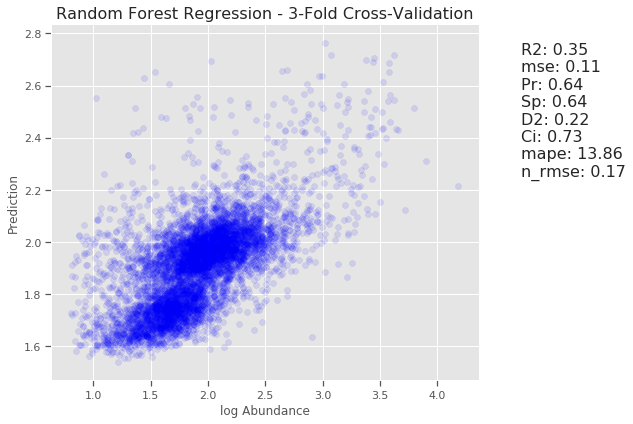

In [20]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('log Abundance')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()

In [21]:
oof_df = pd.DataFrame()
oof_df['oof_mRNAabundance']=all_predictions

In [22]:
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


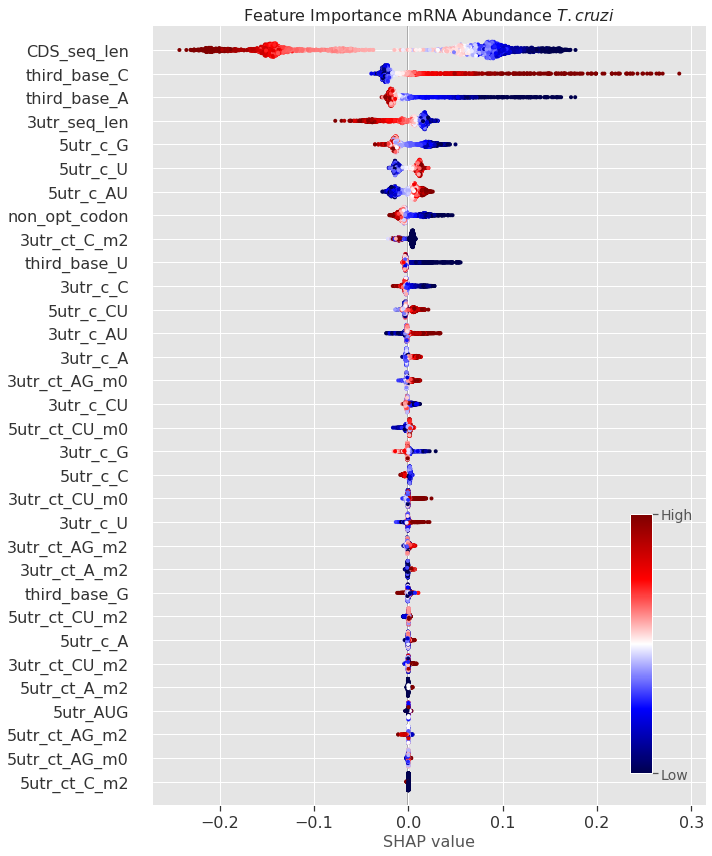

In [23]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance mRNA Abundance $\it{T. cruzi}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_TC_MRNA_abundance.png')
plt.savefig('UTR_seismic_TC_MRNA_abundance.svg')

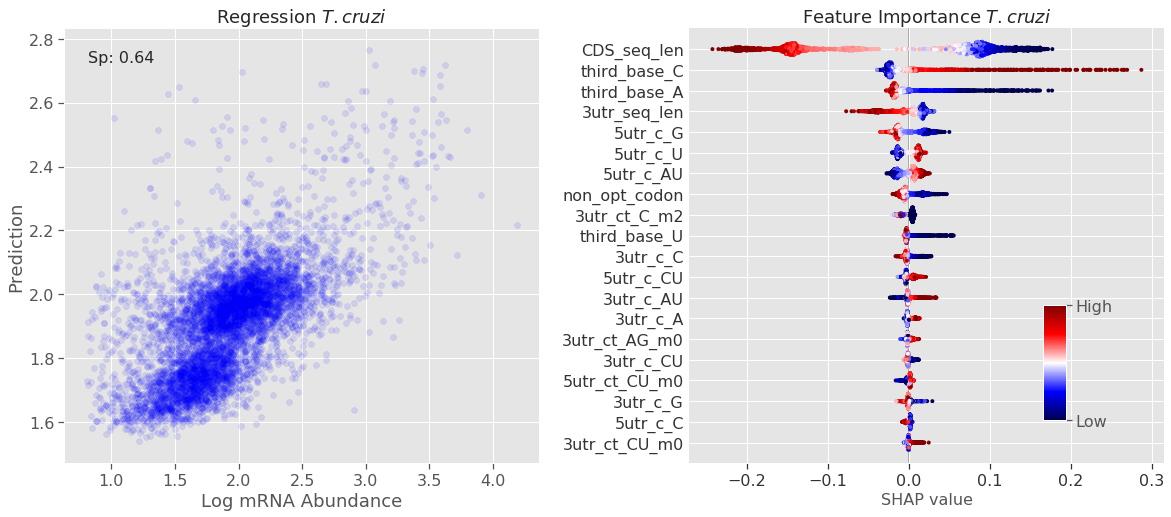

In [24]:
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Log mRNA Abundance', fontsize=18)
axes[0].set_title('Regression $\it{T. cruzi}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. cruzi}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=16)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])

axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)



plt.savefig('Tc_mRNA_Abundance.png', bbox_inches='tight', dpi=300)
plt.savefig('Tc_mRNA_Abundance.svg', bbox_inches='tight')
plt.show()

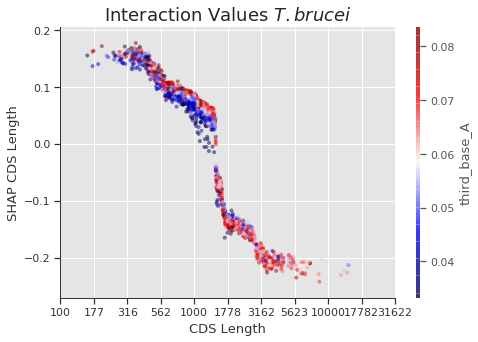

In [25]:
shap.dependence_plot('CDS_seq_len', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',feature_names=feature_names, alpha=0.5)
plt.title('Interaction Values $\it{T. brucei}$',fontsize=18)
plt.ylabel('SHAP CDS Length')
plt.xlabel('CDS Length')
current_ticks = plt.xticks()[0]
new_labels = [str(int(10**x)) for x in current_ticks]
plt.xticks(current_ticks, new_labels)
new_labels[-1]=''
new_labels[0]=''
plt.show()

In [26]:
#pd.concat([results_df.mean(),results_df.std()],axis=1)

In [27]:
results_df = repeated_analysis(X, y)
results_df['analysis_sp']='TC'
results_df['analysis_type']='Abundance_All'
results_df.to_csv('stats_TC_Abundance_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]
results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='TC'
results_df['analysis_type']='Abundance_utr'
results_df.to_csv('stats_TC_Abundance_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='TC'
results_df['analysis_type']='Abundance_codon'
results_df.to_csv('stats_TC_Abundance_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))



  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.6222 ± 0.0159


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.2714 ± 0.0158


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

Average Sp: 0.6226 ± 0.0147


In [28]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['TE']

Fold 1 - R2: 0.3235, RMSE: 0.1287
Fold 2 - R2: 0.3205, RMSE: 0.1268
Fold 3 - R2: 0.3140, RMSE: 0.1293

Overall Metrics:
Mean R2: 0.3193 ± 0.0048
Mean RMSE: 0.1283 ± 0.0013


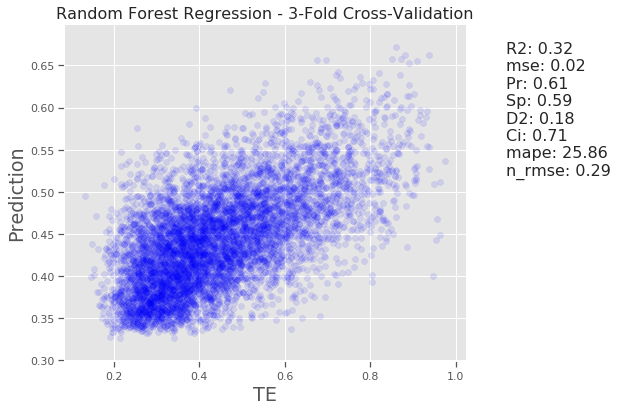

In [29]:
# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']



# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('TE')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
oof_df['oofs_TE']=all_predictions

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


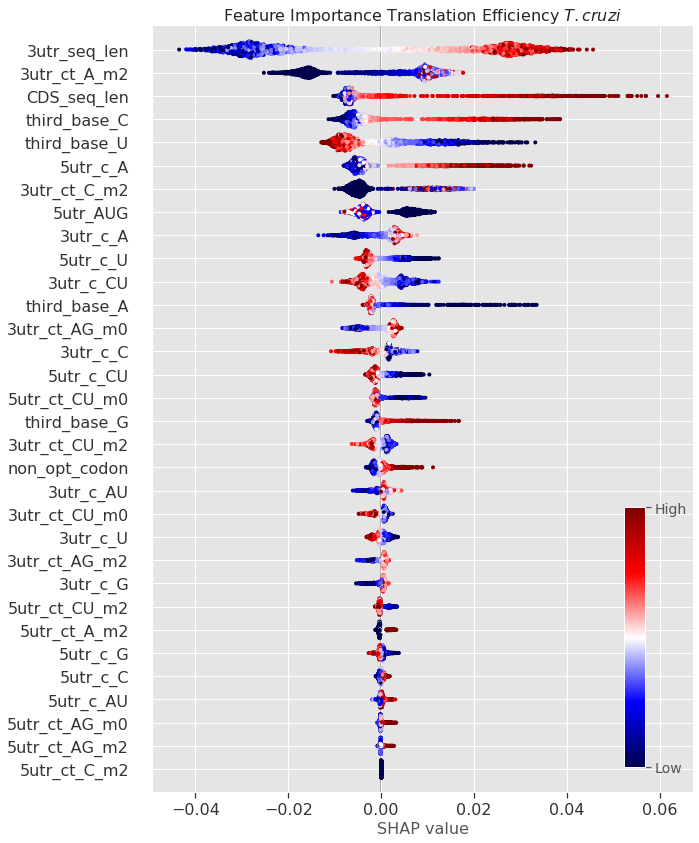

In [31]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance Translation Efficiency $\it{T. cruzi}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_TC_TE.png')
plt.savefig('UTR_seismic_TC_TE.svg')

In [32]:
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

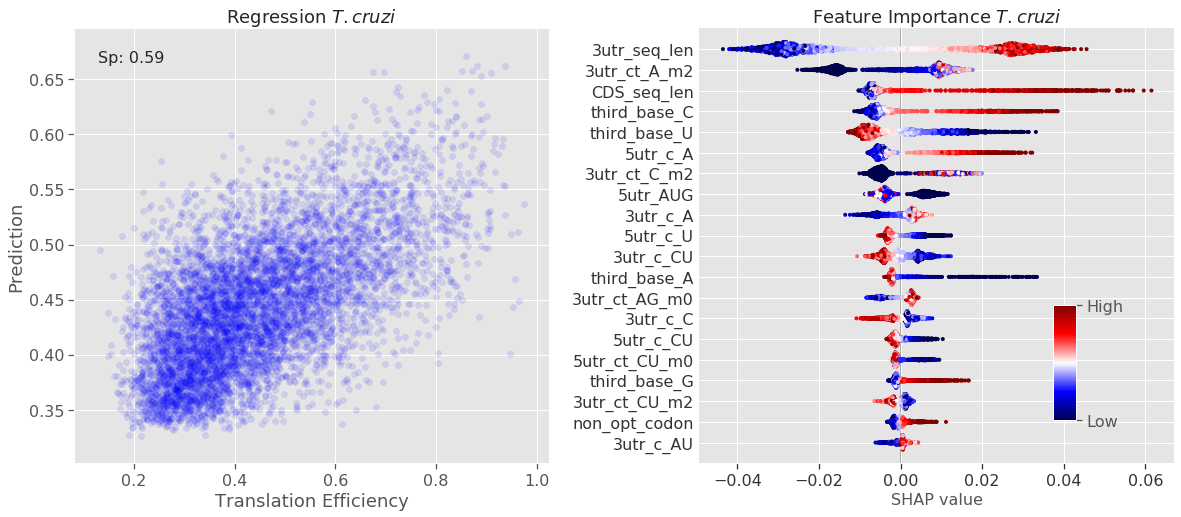

In [33]:
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Translation Efficiency', fontsize=18)
axes[0].set_title('Regression $\it{T. cruzi}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. cruzi}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=16)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])

axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)


plt.savefig('Tc_TE.png', bbox_inches='tight', dpi=300)
plt.savefig('Tc_TE.svg', bbox_inches='tight')
plt.show()

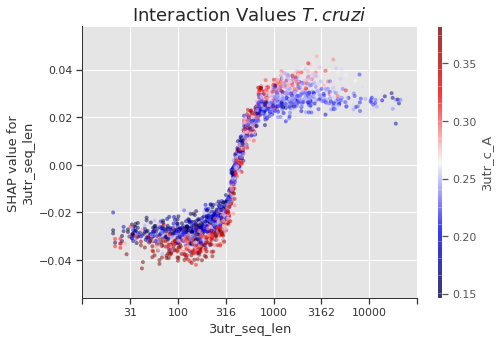

In [34]:
shap.dependence_plot('3utr_seq_len', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',feature_names=feature_names, alpha=0.5)
plt.title('Interaction Values $\it{T. cruzi}$',fontsize=18)
#plt.ylabel('SHAP 3UTR Length')
#plt.xlabel('3UTR Length')
current_ticks = plt.xticks()[0]
new_labels = [str(int(10**x)) for x in current_ticks]
new_labels[-1]=''
new_labels[0]=''
#plt.ylim(-0.1,0.15)
plt.xticks(current_ticks, new_labels)
plt.show()

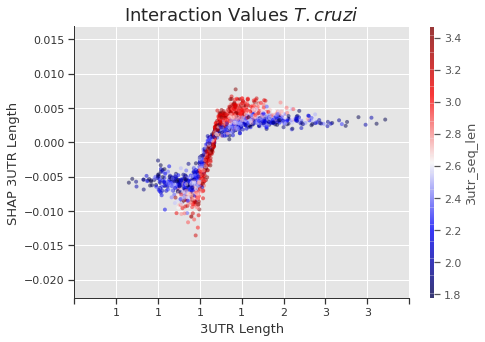

In [35]:
shap.dependence_plot('3utr_c_A', 
                     shap_values, 
                     X_test,show=False,
                     cmap='seismic',feature_names=feature_names, alpha=0.5)
plt.title('Interaction Values $\it{T. cruzi}$',fontsize=18)
plt.ylabel('SHAP 3UTR Length')
plt.xlabel('3UTR Length')
current_ticks = plt.xticks()[0]
new_labels = [str(int(10**x)) for x in current_ticks]
new_labels[-1]=''
new_labels[0]=''
plt.xticks(current_ticks, new_labels)
plt.show()

In [36]:
results_df = repeated_analysis(X, y)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


In [37]:
results_df['analysis_sp']='TC'
results_df['analysis_type']='TE_All'
results_df.to_csv('stats_TC_TE_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

Average Sp: 0.5633 ± 0.0153


In [38]:
only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]

results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='TC'
results_df['analysis_type']='TE_utr'
results_df.to_csv('stats_TC_TE_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))


results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='TC'
results_df['analysis_type']='TE_codon'
results_df.to_csv('stats_TC_TE_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.4704 ± 0.0162


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]

Average Sp: 0.4265 ± 0.0162


In [39]:
# show versions of packages
# adopted from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
import sys
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name.lower()
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
modules = []
for m in sys.builtin_module_names:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'Python BuiltIn'))
        imports.remove(m.lower())

for m in pkg_resources.working_set:
    if m.project_name.lower() in imports and m.project_name!="pip":
        modules.append((m.project_name, m.version))
        imports.remove(m.project_name.lower())

for m in sys.modules:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'unknown'))

# print('System=='+platform.system()+' '+platform.release()+'; Version=='+platform.version())
for r in modules:
    print("{}=={}".format(*r))

sys==Python BuiltIn
tqdm==4.36.1
shap==0.35.0
seaborn==0.9.0
scipy==1.3.2
scikit-learn==0.22
pandas==0.25.2
numpy==1.17.3
matplotlib==3.1.1
types==unknown
re==unknown
pkg_resources==unknown
concordance_index==unknown
repeated_analysis==unknown
cross_validate_random_forest==unknown
norm==unknown


In [40]:
#conda create -n ml_utr python=3.8 matplotlib=3.5.1 numpy=1.21.6 \
#scipy=1.10.1 pandas=1.4.2 scikit-learn=1.0.2 shap=0.39.0 \
#eli5=0.13.0 seaborn=0.11.2 jupyterlab numba=0.53
#conda activate ml_utr
#jupyter lab

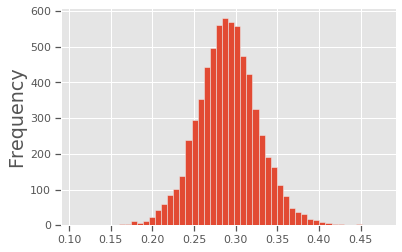

In [41]:
df['non_optimal_codon'].plot(kind='hist',bins=50)